# 多GPU并行

### 单机多卡并行
- 一台机器可以安装多个GPU（1-16）
- 在训练和预测时，将一个小批量计算切分到多个GPU上来达到加速目的
- 常用切分方案有：
  - 数据并行
  - 模型并行
  - 通道并行（数据+模型并行）

#### 数据并行vs模型并行
- 数据并行：将小批量分成n块，每个GPU拿到完整参数计算一块数据的梯度
  - 通常性能更好
  - 在完成每个小批量数据的训练之后，梯度在GPU上聚合
- 模型并行：将模型分成n块，每个GPU拿到一块模型计算其前向和方向结果
  - 通常用于模型大到单GPU放不下
  - 网络并行、分层并行

#### 数据并行
- 一般而言，k个GPU并行训练过程
  - 在任何一次训练迭代中，给定的随机的小批量样本将被分成k个部分，并且均匀分配到GPU上
  - 每个GPU根据分配到的小批量子集， 计算模型参数的损失和梯度
  - 将k个GPU中的局部梯度聚合，以获得当前小批量的随机梯度
  - 聚合梯度被重新分发到**每个GPU**中
  - 每个GPU使用这个小批量随机梯度，来更新其所维护的完整的模型参数集
- 注意：在k个GPU上训练时，需要小批量大小为k的倍数，使得每个GPU都有相同的工作量

### 总结
- 当一个模型能用单卡计算时，通常使用数据并行拓展到多卡上
- 模型并行则用在超大模型上

# 代码

## 多GPU运行 从0开始实现

In [ ]:
!pip install d2l

In [ ]:
import torch

from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

**简单网络LeNet**
- `h2.shape[0]`是批次大小
- `(batch_size, out_channels, height, width)`
- 具体过程：
  - 第一层卷积：输出特征图大小$20\times26\times26$
  - 第一层池化：特征图大小减半$20\times13\times13$
  - 第二层卷积：输出特征图大小$50\times9\times9$
  - 第二层池化：特征图大小减半$50\times4\times4$
  - 展平操作：展平成一个向量，大小$50\times4\times4=800$


In [ ]:
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale  # 20个卷积核，卷积核大小3x3，单输入通道
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale  # 50个卷积核，卷积核大小5x5，输入通道数20
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale     # 全连接层权重，输入维度800（展平后的卷积层输出大小），输出权重128
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale     # 输入维度为128，输出维度为10（输出类别数）
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

def lenet(X, params):
  h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
  h1_activation = F.relu(h1_conv)
  h1 = F.avg_pool2d(input = h1_activation, kernel_size=2, stride=2)

  h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
  h2_activation = F.relu(h2_conv)
  h2 = F.avg_pool2d(input=h2_activation, kernel_size=2, stride=2)

  h2 = h2.reshape(h2.shape[0], -1) # 按批次大小展平（h2.shape[0]是批次大小）

  h3_linear = torch.mm(h2, params[4]) + params[5]
  h3 = F.relu(h3_linear)
  y_hat = torch.mm(h3, params[6]) + params[7]

  return y_hat

loss = nn.CrossEntropyLoss(reduction='none')


#### 数据同步

**向多个设备分发参数**，并且**附加梯度**
- 数据默认在CPU上
-
```
def try_gpu(i=0):
  if torch.cuda.is_available():  
    return torch.device(f'cuda:{i}')
  else:
    return torch.device('cpu')
```

In [ ]:
def get_params(params, device):
  new_params = [p.clone().to(device) for p in params]
  for p in new_params:
    p.requires_grad_()
  return new_params

new_params = get_params(params, d2l.try_gpu(0))
print('b1权重', new_params[1])
print('b1梯度', new_params[1].grad)

b1权重 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1梯度 None


**`allreduce`函数将所有向量相加，并将结果广播给所有GPU**
- **为了保持`data`列表中所有张量的引用不变**，需要使用**切片`[:]`**来进行**就地修改**

In [ ]:
def allreduce(data):
  for i in range(1, len(data)):
    data[0][:] += data[i].to(data[0].device)
  for i in range(1, len(data)):
    data[i][:] = data[0].to(data[i].device)

In [ ]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
allreduce之后：
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


#### 数据分发

**将一个小批量数据均匀分布在多个GPU上**
- **`torch.nn.parallel.scatter(inputs, target_gpus, dim=0`**
  - `dim=0`：指定要分散的维度，通常设置为0，表示沿着第一维度（批次维度）进行分散

In [ ]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

In [ ]:
def split_batch(X, y, devices):
  assert X.shape[0] == y.shape[0]
  return (
      nn.parallel.scatter(X, devices),
      nn.parallel.scatter(y, devices)
  )

#### 训练

**在一个小批量上实现多GPU训练**
-
```
def sgd(params, lr, batch_size):
  with torch.no_gard():
    for param in params:
      if param.grad is not None:
        param -= lr * param.grad / batch_size
      param.grad_zero_()
```
- `device_params`有两个维度
  - `device_params[c]`表第c个设备上的所有参数
  - `device_params[c][i]`表第c个设备上第i层的参数
- `len(device_params[0])`是`device_params`的列数

In [ ]:
def train_batch(X, y, device_params, devices, lr):
  X_shards, y_shards = split_batch(X, y, devices)
  ls = [
      loss(lenet(X_shard, device_W), y_shard).sum()
      for X_shard, y_shard, device_W in zip(X_shards, y_shards, device_params)
  ]
  for l in ls:
    l.backward()
  with torch.no_grad():
    for i in range(len(device_params[0])):
      allreduce([device_params[c][i].grad for c in range(len(devices))])
  for param in device_params:
    d2l.sgd(param, lr, X.shape[0])

**定义训练函数**
- `torch.cuda.synchronize()`用于GPU的同步函数：将当前设备上的CUDA操作排队等待完成
- `lambda x:lenet(x, device_params[0])`匿名函数，作为`evaluate_accuracy_gpu(net, data_iter, device=None)`的第一个参数传入
  - **定义了如何使用`lenet`模型对输入`x`进行前向计算**

In [ ]:
def train(num_gpus, batch_size, lr, num_epochs=10):
  train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
  devices = [d2l.try_gpu(i) for i in range(num_gpus)]
  #
  device_params = [get_params(params, d) for d in devices]
  animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
  timer = d2l.Timer()
  for epoch in range(num_epochs):
    timer.start()
    for X, y in train_iter:
      train_batch(X, y, device_params, devices, lr)
      torch.cuda.synchronize()
    timer.stop()
    # 在GPU0上评估模型
    animator.add(
        epoch + 1,
        (d2l.evaluate_accuracy_gpu(lambda x:lenet(x, device_params[0],), test_iter, devices[0]))
    )
  print(f'测试精度：{animator.Y[0][-1]:.2f}, {timer.avg():.1f}秒/轮，在{str(devices)}')


测试精度：0.85, 7.5秒/轮，在[device(type='cuda', index=0)]


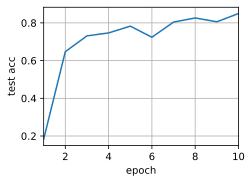

In [ ]:
train(num_gpus=1, batch_size=256, lr=0.2)

In [ ]:
train(num_gpus=2, batch_size=256*2, lr=0.2)

### 练习
1. 在k个GPU上进行训练时，将批量大小从b更改为k*b， 即按GPU的数量进行扩展
2. 比较不同学习率，随着GPU数量的增加，学习率应该如何拓展
  - 可以可视化（如果有多个GPU的话，画在同一图中）
  - 结论：当运行GPU数量增加K倍时，学习率也应该增加k倍
  

RuntimeError: DataLoader worker (pid(s) 12445) exited unexpectedly

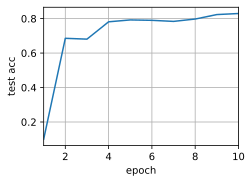

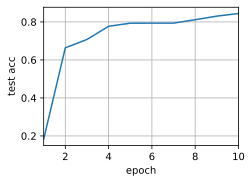

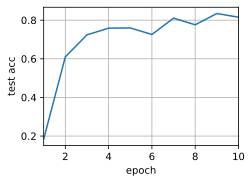

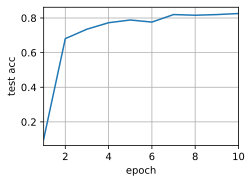

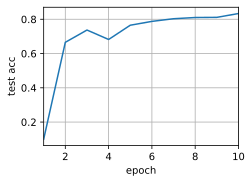

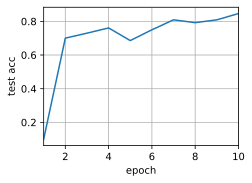

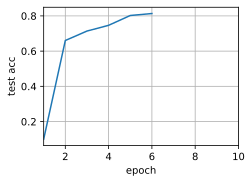

In [ ]:
num_gpus = 1

lr_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
accs = []
for lr in lr_list:
  acc = {}
  for i in range(num_gpus):
    acc[str(i)] = train(num_gpus, batch_size=256, lr=0.2)
  acc['lr'] = lr
  accs.append(acc)

3. 实现一个更高效的`allreduce`函数用于在不同的GPU上聚合不同的参数？为什么这样的效率更高？

4. 实现模型在多GPU下测试精度的计算

In [ ]:
def evaluate_accuracy_gpus(data_iter, devices, device_params):
  metric = d2l.Accumulator(2)
  with torch.no_grad():
    for X, y in data_iter:
      X_shards, y_shards = split_batch(X, y, devices)
      metrics = 0
      for X_shard, y_shard, device_w in zip(X_shards, y_shards, device_params):
        if X_shard.device != device_w[0].device:
          X_shard = X_shard.to(device_w[0].device)
          y_shard = y_shard.to(device_w[0].device)
        y_pred = lenet(X_shard, device_w)
        metrics += d2l.accuracy(y_pred, y_shard)
      metric.add(metrics, y.numel())
  return metric[0] / metric[1]

def train(num_gpus, batch_size, lr, num_epochs=10):
  train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
  devices = [d2l.try_gpu(i) for i in range(num_gpus)]
  device_params = [get_params(params, d) for d in devices]
  animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
  timer = d2l.Timer()
  for epoch in range(num_epochs):
    timer.start()
    for X, y in train_iter:
      train_batch(X, y, device_params, devices, lr)
      torch.cuda.synchronize()
    timer.stop()
    animator.add(epoch + 1, (evaluate_accuracy_gpus(test_iter, devices, device_params)))
  print(f'测试精度：{animator.Y[0][-1]:.2f}, {timer.avg():.1f}, 在{str(devices)}')
  return animator.Y[0][-1]

测试精度：0.85, 7.7, 在[device(type='cuda', index=0)]


0.8499

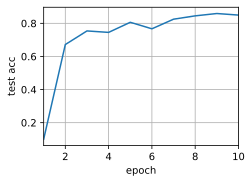

In [ ]:
train(num_gpus=1, batch_size=256, lr=0.4)

## 多GPU的简洁实现

#### 简单网络
**使用ResNet-18**
- 也可以使用`net.add_module('layer_name', net_)`

In [ ]:
from torch.nn import functional as F

class Residual(nn.Module):
  def __init__(self, in_channels, out_channels, use_1x1_conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    if use_1x1_conv:
      self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

def resnet18(num_classes, in_channels=1):
  def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
      if i == 0 and not first_block:
        blk.append(Residual(in_channels, out_channels, use_1x1_conv=True, strides=2))
      else:
        blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)

  # resnet-18模型稍加改变：使用了更小的卷积核、步长和填充，而且删除了最大汇聚层
  b1 = nn.Sequential(
      nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU()
  )
  b2 = resnet_block(64, 64, 2, first_block=True)
  b3 = resnet_block(64, 128, 2)
  b4 = resnet_block(128, 256, 2)
  b5 = resnet_block(256, 512, 2)
  net = nn.Sequential(
      b1, b2, b3, b4, b5,
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(),
      nn.Linear(512, num_classes)
  )
  return net

In [ ]:
net = resnet18(10)
devices = d2l.try_all_gpus()

#### 训练
几个基本功能：
- 在所有设备上初始化网络参数
- 在数据集上迭代时，将小批量数据分配到所有设备上
- 跨设备并行计算损失及其梯度
- 聚合梯度，并相应地更新参数

**注意**：
- **`nn.DataParallel`用于在多GPU上并行训练模型**
  - 自动将模型的输入分割到多个GPU上，计算完每个GPU上的梯度后，将梯度汇总（平均或加和），再将更新后的模型参数同步到各个GPU，从而实现数据并行的训练方式
  - `nn.DataParallel`要求输入的数据**最初在主GPU**（即`device_ids`列表中的第一个GPU）上，之后会将数据从主GPU复制到其他GPU上
    - 如果不在，则需要先把数据传输到主GPU，再进行分发

In [ ]:
def train(net, num_gpus, batch_size, lr, num_epochs=10):
  train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
  devices = [d2l.try_gpu(i) for i in range(num_gpus)]

  def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
      nn.init.normal_(m.weight, std=0.01)
  net.apply(init_weights)

  net = nn.DataParallel(net, device_ids=devices)

  trainer = torch.optim.SGD(net.parameters(), lr)
  loss = nn.CrossEntropyLoss()
  timer = d2l.Timer()
  animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
  for epoch in range(num_epochs):
    net.train()
    timer.start()
    for X, y in train_iter:
      trainer.zero_grad()
      X, y = X.to(devices[0]), y.to(devices[0])
      l =loss(net(X), y)
      l.backward()
      trainer.step()
    timer.stop()
    animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
  print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，在{str(devices)}')

测试精度：0.92，43.7秒/轮，在[device(type='cuda', index=0)]


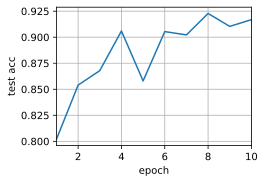

In [ ]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

In [ ]:
train(net, num_gpus=2, batch_size=512, lr=0.2) # 对于此数据集，这个batch_size有点大了可能

### 练习
1. 本节使用ResNet-18，请尝试不同的迭代周期数、批量大小和学习率，以及使用更多的GPU进行计算。如果使用$16$个GPU（例如，在AWS p2.16xlarge实例上）尝试此操作，会发生什么？

In [ ]:
from torch.nn import functional as F

class Residual(nn.Module):
  def __init__(self, in_channels, out_channels, use_1x1_conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    if use_1x1_conv:
      self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

def resnet18(num_classes, in_channels=1):
  def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
      if i == 0 and not first_block:
        blk.append(Residual(in_channels, out_channels, use_1x1_conv=True, strides=2))
      else:
        blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)

  net = nn.Sequential(
      nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU()
  )
  net.add_module('resnet_block1', resnet_block(64, 64, 2, first_block=True))
  net.add_module('resnet_block2', resnet_block(64, 128, 2))
  net.add_module('resnet_block2', resnet_block(128, 256, 2))
  net.add_module('resnet_block2', resnet_block(256, 512, 2))
  net.add_module('global_avg_pool', nn.AdaptiveAvgPool2d((1, 1)))
  net.add_module('fc', nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))

  return net

net = resnet18(10)

def train(net, num_gpus, batch_size, lr, num_epochs=10):
  train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
  devices = [d2l.try_gpu(i) for i in range(num_gpus)]
  def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
      nn.init.normal_(m.weight, std=0.01)
  net.apply(init_weights)

  net = nn.DataParallel(net, devices)
  device = devices[0]

  trainer = torch.optim.SGD(net.parameters(), lr)
  loss =  nn.CrossEntropyLoss()
  timer = d2l.Timer()
  animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
  for epoch in range(num_epochs):
    net.train()
    timer.start()
    for X, y in train_iter:
      trainer.zero_grad()
      X, y = X.to(device), y.to(device)
      l = loss(net(X), y)
      l.backward()
      trainer.step()
    timer.stop()
    animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
  print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，在{str(devices)}')
  return animator.Y[0][-1]

测试精度：0.89，43.8秒/轮，在[device(type='cuda', index=0)]


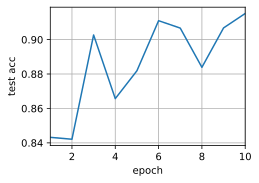

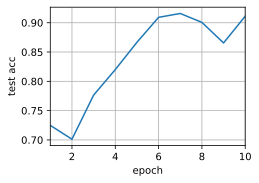

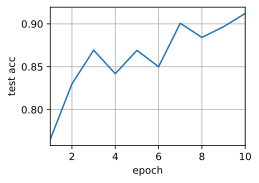

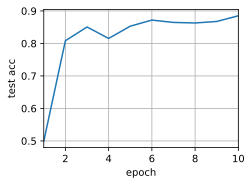

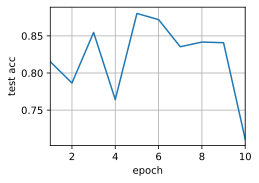

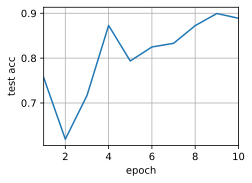

In [ ]:
lr_list = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55]

accs = []

for lr in lr_list:
  acc = {}
  acc['result'] = train(net, num_gpus=1, batch_size=256, lr=lr)
  acc['lr'] = lr
  accs.append(acc)

In [ ]:
# 跑不了
import time

accs = []
gpus = range(1, 9)
for gpu in gpus:
  acc = {}
  start_time = time.time()
  acc['result'] = train(net, num_gpus=gpu, batch_size=256 * gpu, lr=0.2)
  acc['time'] = time.time() - start_time
  accs.append(acc)

2. 有时候不同的设备提供了不同的计算能力，我们可以同时使用GPU和CPU，那应该如何分配工作？为什么？
- 一般策略如下
  - **数据预处理和后处理**：通常情况下，计算量较小，可以将其分配给CPU处理。CPU在处理这些任务时通常更有效率（具有更强大的通用计算能力）
  - **训练模型**：将神经网络的前向传播和反向传播过程分配给GPU来处理。GPU在行大规模矩阵计算和并行计算任务时非常强大，特别适合深度学习模型的训练过程